In [1]:
## The goal of this notebook is build two models, Naive Bayes and Maximum Entropy, 
## and to compare their performances on various CV data sets

In [2]:
## import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import random
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from collections import Counter
import scipy.sparse
from prettytable import PrettyTable
import gc
gc.collect()

## display plots inline
%matplotlib inline

## load the processed training-set tweets
## use the small processed training-set tweets for debugging
small = False
if small:
  df = pd.read_pickle('../tweet_data/training_data/training_data_small_processed.pkl')
  df_cv = pd.read_pickle('../tweet_data/training_data/training_data_small_cv_processed.pkl') 
else:
  df = pd.read_pickle('../tweet_data/training_data/training_data_processed.pkl')
  df_cv = pd.read_pickle('../tweet_data/training_data/training_data_cv_processed.pkl')  

## load the processed test-set tweets
df_sa = pd.read_pickle('../tweet_data/cv_data/sanders_analytics/sanders_analytics_cv_data_processed.pkl')
df_s140 = pd.read_pickle('../tweet_data/cv_data/sentiment140/sentiment140_cv_data_processed.pkl')

if small:
  path = '../model_parameters/small_'
else:
  path = '../model_parameters/'
  
print 'training data set size:', len(df)
print 'training-cv data set size:', + len(df_cv)
print 'Sentiment 140 (S140) cv data set size:', len(df_s140)
print 'Sanders anlaytics (SA) cv data set size:', len(df_sa)

training data set size: 891561
training-cv data set size: 222891
Sentiment 140 (S140) cv data set size: 497
Sanders anlaytics (SA) cv data set size: 2624


In [3]:
## some useful functions

## sentiment statistics
def sentiment_stats(DF):
  return [1.0*sum(DF['sentiment']==-1)/len(DF), 1.0*sum(DF['sentiment']==0)/len(DF), \
          1.0*sum(DF['sentiment']==1)/len(DF)]

## emoticon statistics
def emoticon_stats(DF):
  neg_emoticon_counter = 0
  pos_emoticon_counter = 0
  for i in range(len(DF)):
    if DF['sentiment'].iloc[i] == -1:
      neg_emoticon_counter += Counter(DF['words'].iloc[i])['negemoticontoken']
    if DF['sentiment'].iloc[i] == 1:
      pos_emoticon_counter += Counter(DF['words'].iloc[i])['posemoticontoken']
  return [float(neg_emoticon_counter)/sum(DF['sentiment']==-1), \
          float(pos_emoticon_counter)/sum(DF['sentiment']==1)]

print 'training emoticon fractions:', emoticon_stats(df)
print 'CV emoticon fractions:', emoticon_stats(df_cv)
print 'S140 emoticon fractions:', emoticon_stats(df_s140)
print 'SA emoticon fractions:', emoticon_stats(df_sa)

training emoticon fractions: [0.06314206206866384, 0.06759380457422431]
CV emoticon fractions: [0.061779075871165726, 0.06762049611693607]
S140 emoticon fractions: [0.06779661016949153, 0.11049723756906077]
SA emoticon fractions: [0.024282560706401765, 0.05089058524173028]


In [4]:
## build the bag of words
ranks_tot = [item for sublist in df['word_ranks'] for item in sublist]
ranks_tot_neg = [item for sublist in df['word_ranks'][df['sentiment'] == -1] for item in sublist]
ranks_tot_neutral = [item for sublist in df['word_ranks'][df['sentiment'] == 0] for item in sublist]
ranks_tot_pos = [item for sublist in df['word_ranks'][df['sentiment'] == 1] for item in sublist]
counter = Counter(ranks_tot)
counter_neg = Counter(ranks_tot_neg)
counter_neutral = Counter(ranks_tot_neutral)
counter_pos = Counter(ranks_tot_pos)
max_rank = max(ranks_tot)+1

## put the CV sets into word rank form
words_tot = [item for sublist in df['words'] for item in sublist]
count = Counter(words_tot).most_common()
words_unique = [count[i][0] for i in range(len(count))]
words_frequencies = [count[i][1] for i in range(len(count))]

def word_to_rank(x):
  return sorted([ words_unique.index(w) for w in x if w in words_unique])

df_s140['word_ranks'] = df_s140['words'].map(word_to_rank)
df_sa['word_ranks'] = df_sa['words'].map(word_to_rank)

In [5]:
## example for blog write-up
print len(df_s140['words'].iloc[15]) - len(df_s140['word_ranks'].iloc[15])
print df_s140['words'].iloc[15] 
print df_s140['word_ranks'].iloc[15]

0
[u'wa', u'talking', u'guy', u'last', u'night', u'wa', u'telling', u'die', u'hard', u'spur', u'fan', u'also', u'told', u'hate', u'lebron', u'james']
[5, 5, 78, 88, 92, 122, 128, 202, 256, 545, 551, 631, 1181, 1642, 6042, 12014]


In [6]:
################################################################
## Naive Bayes classifier

In [7]:
##re-think Laplace smoothing now that I'm ignoring new words in cv set

## priors
prior_neg = float(sum(df['sentiment']==-1))/len(df)
prior_neutral = float(sum(df['sentiment']==0))/len(df)
prior_pos = float(sum(df['sentiment']==1))/len(df)

## conditional probabilities of word given class (with Laplace smoothing parameter alpha)
alpha = 1 # Laplace smoothing parameter
def p_rank_given_neg(rank):
  return float(counter_neg[rank] + alpha)/(len(ranks_tot_neg) + alpha*len(ranks_tot))
def p_rank_given_neutral(rank):
  return float(counter_neutral[rank] + alpha)/(len(ranks_tot_neutral) + alpha*len(ranks_tot))
def p_rank_given_pos(rank):
  return float(counter_pos[rank] + alpha)/(len(ranks_tot_pos) + alpha*len(ranks_tot))

## class prediction
def NB_predict(rank_list):
  p_neg = math.log(prior_neg) + sum([math.log(p_rank_given_neg(i)) for i in rank_list])
  p_neutral = math.log(prior_neutral) + sum([math.log(p_rank_given_neutral(i)) for i in rank_list])
  p_pos = math.log(prior_pos) + sum([math.log(p_rank_given_pos(i)) for i in rank_list])
  return -1 + [p_neg, p_neutral, p_pos].index(max([p_neg, p_neutral, p_pos]))

df_cv['NB predictions'] = df_cv['word_ranks'].map(NB_predict)
df_sa['NB predictions'] = df_sa['word_ranks'].map(NB_predict)
df_s140['NB predictions'] = df_s140['word_ranks'].map(NB_predict)

## Classification error
## training CV set
NB_accuracy_cv = 100*float(sum(df_cv['NB predictions'] == df_cv['sentiment']))/len(df_cv)
NB_accuracy_cv_neg = 100.0*sum(df_cv[df_cv['sentiment'] == -1]['NB predictions'] == df_cv[df_cv['sentiment'] == -1]['sentiment'])\
                    /len(df_cv[df_cv['sentiment'] == -1])
NB_accuracy_cv_neutral = 100.0*sum(df_cv[df_cv['sentiment'] == 0]['NB predictions'] == df_cv[df_cv['sentiment'] == 0]['sentiment'])\
                    /len(df_cv[df_cv['sentiment'] == 0])
NB_accuracy_cv_pos = 100.0*sum(df_cv[df_cv['sentiment'] == 1]['NB predictions'] == df_cv[df_cv['sentiment'] == 1]['sentiment'])\
                    /len(df_cv[df_cv['sentiment'] == 1])
## S140 set
NB_accuracy_s140 = 100*float(sum(df_s140['NB predictions'] == df_s140['sentiment']))/len(df_s140)
NB_accuracy_s140_neg = 100.0*sum(df_s140[df_s140['sentiment'] == -1]['NB predictions'] == df_s140[df_s140['sentiment'] == -1]['sentiment'])\
                    /len(df_s140[df_s140['sentiment'] == -1])
NB_accuracy_s140_neutral = 100.0*sum(df_s140[df_s140['sentiment'] == 0]['NB predictions'] == df_s140[df_s140['sentiment'] == 0]['sentiment'])\
                    /len(df_s140[df_s140['sentiment'] == 0])
NB_accuracy_s140_pos = 100.0*sum(df_s140[df_s140['sentiment'] == 1]['NB predictions'] == df_s140[df_s140['sentiment'] == 1]['sentiment'])\
                    /len(df_s140[df_s140['sentiment'] == 1])
## SA set
NB_accuracy_sa = 100*float(sum(df_sa['NB predictions'] == df_sa['sentiment']))/len(df_sa)
NB_accuracy_sa_neg = 100.0*sum(df_sa[df_sa['sentiment'] == -1]['NB predictions'] == df_sa[df_sa['sentiment'] == -1]['sentiment'])\
                    /len(df_sa[df_sa['sentiment'] == -1])
NB_accuracy_sa_neutral = 100.0*sum(df_sa[df_sa['sentiment'] == 0]['NB predictions'] == df_sa[df_sa['sentiment'] == 0]['sentiment'])\
                    /len(df_sa[df_sa['sentiment'] == 0])
NB_accuracy_sa_pos = 100.0*sum(df_sa[df_sa['sentiment'] == 1]['NB predictions'] == df_sa[df_sa['sentiment'] == 1]['sentiment'])\
                    /len(df_sa[df_sa['sentiment'] == 1])

## examine performance
print 'Naive Bayes Performance:'
pt = PrettyTable(field_names=['data set', 'accuracy', '(-) accuracy', '(0) accuracy', '(+) accuracy']) 
[ pt.add_row(['CV', round(NB_accuracy_cv, 2), round(NB_accuracy_cv_neg, 2), \
              round(NB_accuracy_cv_neutral, 2), round(NB_accuracy_cv_pos, 2) ])]

[ pt.add_row(['S140', round(NB_accuracy_s140, 2), round(NB_accuracy_s140_neg, 2), \
              round(NB_accuracy_s140_neutral, 2), round(NB_accuracy_s140_pos, 2) ])]

[ pt.add_row(['SA', round(NB_accuracy_sa, 2), round(NB_accuracy_sa_neg, 2), \
              round(NB_accuracy_sa_neutral, 2), round(NB_accuracy_sa_pos, 2) ])]

#pt.align['Word'], pt.align['Count'] = 'l', 'r' #set column alignment
print pt

Naive Bayes Performance:
+----------+----------+--------------+--------------+--------------+
| data set | accuracy | (-) accuracy | (0) accuracy | (+) accuracy |
+----------+----------+--------------+--------------+--------------+
|    CV    |   77.8   |     68.7     |    93.85     |    70.87     |
|   S140   |  55.73   |    50.28     |    64.75     |    54.14     |
|    SA    |  51.94   |    33.77     |    57.82     |    46.31     |
+----------+----------+--------------+--------------+--------------+


In [8]:
## Save the NB model variables
np.save(path + 'words_unique', words_unique)
np.save(path + 'prior_neg', prior_neg)
np.save(path + 'prior_neutral', prior_neutral)
np.save(path + 'prior_pos', prior_pos)
np.save(path + 'ranks_tot', ranks_tot)
np.save(path + 'ranks_tot_neg', ranks_tot_neg)
np.save(path + 'ranks_tot_neutral', ranks_tot_neutral)
np.save(path + 'ranks_tot_pos', ranks_tot_pos)

In [9]:
################################################################
## MaxEnt Classifier

In [10]:
## create the sparse feature matrices
def feature_matrix(df):
  feature = scipy.sparse.lil_matrix((len(df), max_rank))
  for j in range(len(df)):
    for i in range(len(df['word_ranks'].iloc[j])):
      feature[j, df['word_ranks'].iloc[j][i]] += 1.0/(len(df['word_ranks'].iloc[j]))
  return scipy.sparse.csr_matrix(feature) ## convert into csr matrix

feature = feature_matrix(df)
feature_cv = feature_matrix(df_cv)
feature_s140 = feature_matrix(df_s140)
feature_sa = feature_matrix(df_sa)

## define a special function to save it
def save_sparse_csr(filename, array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

save_sparse_csr(path + 'feature', feature)

In [11]:
## useful functions

## compute the average log likelihood
def loglike(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta):
  ## class indicator functions
  I_neg = np.array(df['sentiment']== -1, dtype=float)
  I_neutral = np.array(df['sentiment']== 0, dtype=float)
  I_pos = np.array(df['sentiment']== 1, dtype=float)
  ## useful factors
  flambda_neg = feature.dot(lambda_neg)
  flambda_neutral = feature.dot(lambda_neutral)
  flambda_pos = feature.dot(lambda_pos)
  return (flambda_neg.dot(I_neg) + flambda_neutral.dot(I_neutral) + flambda_pos.dot(I_pos) \
    - sum(np.log(np.exp(flambda_neg) + np.exp(flambda_neutral) + np.exp(flambda_pos))))/len(df) \
    - (beta/2)*sum(lambda_neg*lambda_neg + lambda_neutral*lambda_neutral + lambda_pos*lambda_pos)/len(df)

## compute the gradient 
def gradient(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta):
  ## class indicator functions
  I_neg = np.array(df['sentiment']== -1, dtype=float)
  I_neutral = np.array(df['sentiment']== 0, dtype=float)
  I_pos = np.array(df['sentiment']== 1, dtype=float)
  ## useful factors
  flambda_neg = feature.dot(lambda_neg)
  flambda_neutral = feature.dot(lambda_neutral)
  flambda_pos = feature.dot(lambda_pos)
  ## boltzmann factors
  boltz_neg = np.exp(flambda_neg)
  boltz_neutral = np.exp(flambda_neutral)
  boltz_pos = np.exp(flambda_pos)
  ## the gradients
  dLLdlambda_neg = (feature.transpose().dot(I_neg) \
                    - feature.transpose().dot( (boltz_neg/(boltz_neg + boltz_neutral + boltz_pos))))/len(df)
  dLLdlambda_neutral = (feature.transpose().dot(I_neutral) \
                        - feature.transpose().dot( (boltz_neutral/(boltz_neg + boltz_neutral + boltz_pos))))/len(df)
  dLLdlambda_pos = (feature.transpose().dot(I_pos) \
                    - feature.transpose().dot( (boltz_pos/(boltz_neg + boltz_neutral + boltz_pos))))/len(df)
  ## add L2 regularization
  dLLdlambda_neg = dLLdlambda_neg - beta*lambda_neg/len(df)
  dLLdlambda_neutral = dLLdlambda_neutral - beta*lambda_neutral/len(df)
  dLLdlambda_pos = dLLdlambda_pos - beta*lambda_pos/len(df)  
  return [dLLdlambda_neg, dLLdlambda_neutral, dLLdlambda_pos]

## prediction accuracy
def ME_predictions(df, feature, lambda_neg, lambda_neutral, lambda_pos):
  ## useful factors
  flambda_neg = feature.dot(lambda_neg)
  flambda_neutral = feature.dot(lambda_neutral)
  flambda_pos = feature.dot(lambda_pos)
  ## boltzmann factors
  boltz_neg = np.squeeze(np.asarray(np.exp(flambda_neg)))
  boltz_neutral = np.squeeze(np.asarray(np.exp(flambda_neutral)))
  boltz_pos = np.squeeze(np.asarray(np.exp(flambda_pos)))
  predict = []
  for i in range(len(df)):
    p_neg = boltz_neg[i]
    p_neutral = boltz_neutral[i]
    p_pos = boltz_pos[i]
    predict.append(-1 + [p_neg, p_neutral, p_pos].index(max([p_neg, p_neutral, p_pos])))
  return predict

## compute gradient via finite differences
def gradient_FD(lambda_neg, lambda_neutral, lambda_pos, epsilon, beta):
  LL1 = loglike(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta)
  dLLdlambda_neg_FD = [0 for i in range(max_rank)]
  dLLdlambda_neutral_FD = [0 for i in range(max_rank)]
  dLLdlambda_pos_FD = [0 for i in range(max_rank)]
  
  ## negative
  for i in range(len(lambda_neg)):
    lambda_neg2 = np.copy(lambda_neg)
    lambda_neutral2 = np.copy(lambda_neutral)
    lambda_pos2 = np.copy(lambda_pos)
    lambda_neg2[i] += epsilon #update only the neg lambda    
    LL2 = loglike(df, feature, lambda_neg2, lambda_neutral2, lambda_pos2, beta)
    dLLdlambda_neg_FD[i] = (LL2 - LL1)/epsilon
    
  ## neutral
  for i in range(len(lambda_neg)):
    lambda_neg2 = np.copy(lambda_neg)
    lambda_neutral2 = np.copy(lambda_neutral)
    lambda_pos2 = np.copy(lambda_pos)
    lambda_neutral2[i] += epsilon #update only the neutral lambda    
    LL2 = loglike(df, feature, lambda_neg2, lambda_neutral2, lambda_pos2, beta)
    dLLdlambda_neutral_FD[i] = (LL2 - LL1)/epsilon

  ## positive
  for i in range(len(lambda_neg)):
    lambda_neg2 = np.copy(lambda_neg)
    lambda_neutral2 = np.copy(lambda_neutral)
    lambda_pos2 = np.copy(lambda_pos)
    lambda_pos2[i] += epsilon #update only the pos lambda    
    LL2 = loglike(df, feature, lambda_neg2, lambda_neutral2, lambda_pos2, beta)
    dLLdlambda_pos_FD[i] = (LL2 - LL1)/epsilon
    
  return [dLLdlambda_neg_FD, dLLdlambda_neutral_FD, dLLdlambda_pos_FD]

In [12]:
## check the gradient against finite differences (only use for small data sets, takes long time otherwise)
gradcheck = False

if gradcheck:
  beta = 11.0
  grad_ME = gradient(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta)
  np.random.seed(seed=1)
  lambda_neg = np.random.uniform(0,1,max_rank)
  lambda_neutral = np.random.uniform(0,1,max_rank)
  lambda_pos = np.random.uniform(0,1,max_rank)

  ## check to see that the difference scales like epsilon
  grad_FD = gradient_FD(lambda_neg, lambda_neutral, lambda_pos, 0.01, beta)
  print [ sum(grad_ME[0] - grad_FD[0])/len(grad_ME[0]), sum(grad_ME[1] - grad_FD[1])/len(grad_ME[1]), \
       sum(grad_ME[2] - grad_FD[2])/len(grad_ME[2])]

  grad_FD = gradient_FD(lambda_neg, lambda_neutral, lambda_pos, 0.001, beta)
  print [ sum(grad_ME[0] - grad_FD[0])/len(grad_ME[0]), sum(grad_ME[1] - grad_FD[1])/len(grad_ME[1]), \
       sum(grad_ME[2] - grad_FD[2])/len(grad_ME[2])]

In [14]:
beta_list = [(2)**(1-j) for j in range(10)]
print beta_list

[2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625]


In [15]:
## Training

## Note to self: the optimization problem is concave so the training log likelihood should always increase,
## assuming the learning rate is small enough. If we get too close to the global max, the lambda's will be really 
## small and the change in log likelihood will be dominated by noise, and so may increase. This should indicate
## end of training, and not a problem with the code, especially since I checked the gradients above.

## ideas for faster convergence
## 1. momentum method
## 2. line search

alpha_init = 500 ## initial learning rate
max_grad_TOL = 1e-6 ## when the maximum gradient is smaller than this, consider it converged
Nitermax = 1e6
m_eval = 10 ## evaluate only every m_eval iterations
alpha_min = 1e-3  ## if alpha decays past this, something's gone wrong
zigzag_TOL = 1e-3
## initialize some lists
lambda_list = []
LL = []
LL_cv = []

## scan over values of the regulator variable
for j in range(len(beta_list)):
  beta = beta_list[j]
  ## create the vector of parameters to be learned (initialized to zero)
  lambda_neg = np.zeros(max_rank)
  lambda_neutral = np.zeros(max_rank)
  lambda_pos = np.zeros(max_rank)
  ## the initial LL and accuracy for training set and cv set
  LL_history = [loglike(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta)]
  LL_cv_history = [loglike(df_cv, feature_cv, lambda_neg, lambda_neutral, lambda_pos, 0)]
  max_grad_history = [10]
  
  ## gradient ascent
  cond = True
  i = 0
  alpha = alpha_init ## learning rate
  print 'beta = ', beta
  while cond:    
    ## compute the gradients
    [dLLdlambda_neg, dLLdlambda_neutral, dLLdlambda_pos] = gradient(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta)
    ## record the current values
    if i % m_eval == 0:
      lambda_neg_old = lambda_neg
      lambda_neutral_old = lambda_neutral
      lambda_pos_old = lambda_pos
    ## advance the parameters
    lambda_neg = lambda_neg + alpha*dLLdlambda_neg
    lambda_neutral = lambda_neutral + alpha*dLLdlambda_neutral
    lambda_pos = lambda_pos + alpha*dLLdlambda_pos
    
    if i % m_eval == 0:
      ## compute some diagnostics
      LL_current = loglike(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta)
      LL_cv_current = loglike(df_cv, feature_cv, lambda_neg, lambda_neutral, lambda_pos, 0)
      max_grad = np.max(np.abs(np.concatenate((dLLdlambda_neg, dLLdlambda_neutral, dLLdlambda_pos), axis=0)))

      ## decay learning rate if log likelihood decreases before convergence or if we enter a zigzag loop
      zigzag = np.abs((max_grad - max_grad_history[-1])/max_grad) < zigzag_TOL #not sure if this is the best way to detect zigzags
      LL_decrease = LL_current < LL_history[-1]
      alpha_decay = (LL_decrease or zigzag) and (max_grad_history[-1] > max_grad_TOL)
      if alpha_decay:
        ## reset the lambdas
        lambda_neg = lambda_neg_old
        lambda_neutral = lambda_neutral_old
        lambda_pos = lambda_pos_old
        ## decay alpha
        alpha = 0.75*alpha
        if LL_decrease:
          print 'i = ', i, 'LL decreased', 'LL = ', LL_current, 'max_grad=', max_grad, 'decaying alpha to = ', alpha
        if zigzag:
          print 'i = ', i, 'entered zigzag', 'LL = ', LL_current, 'max_grad=', max_grad, 'decaying alpha to = ', alpha
  
      ## record-keeping
      if not alpha_decay:
        LL_history.append(LL_current)
        LL_cv_history.append(LL_cv_current)
        max_grad_history.append(max_grad)    
        
      ## print out every 1000 iterations
      if i % 1000 == 0:
        print 'i=', i, 'LL=', [LL_history[-1], LL_cv_history[-1]], 'max_grad=', max_grad_history[-1]
      
    ## advance the gradient ascent iterations
    i += 1
    
    ## end the training if it has converged
    if max_grad < max_grad_TOL:
      ## compute the derivatives at the final stopping point
      [dLLdlambda_neg, dLLdlambda_neutral, dLLdlambda_pos] = gradient(df, feature, lambda_neg, lambda_neutral, lambda_pos, beta)
      max_grad = np.max(np.abs(np.concatenate((dLLdlambda_neg, dLLdlambda_neutral, dLLdlambda_pos), axis=0)))
      print '\ntraining halted: gradients converged'
      print 'training iterations:', i, 'LL=', [LL_history[-1], LL_cv_history[-1]]
      print 'max_grad: ', max_grad, '\n'
      print '------------------------------------------------------------------------'
      cond = False
    
    ## end the training if something has gone wrong
    if i == Nitermax or alpha < alpha_min:
      print '\ntraining halted: Nitermax reached or alpha decayed to insanely small value'
      print 'training iterations:', i
      print 'LL=', [LL_history[-1], LL_cv_history[-1]]
      print 'max_grad: ', max_grad, '\n'
      print '------------------------------------------------------------------------'
      cond = False
    
  ## Save the ME parameters at the end of every successful iteration
  lambda_list.append([lambda_neg, lambda_neutral, lambda_pos])
  LL.append(LL_history)
  LL_cv.append(LL_cv_history)
  np.save(path + 'lambda_list', lambda_list)
  np.save(path + 'beta_list', beta_list[:j+1])
  np.save(path + 'LL_cv', LL_cv)
  np.save(path + 'LL', LL)

beta =  2
i =  0 LL decreased LL =  -1.10568489607 max_grad= 0.0214644046296 decaying alpha to =  375.0
i= 0 LL= [-1.0986122886862781, -1.0986122886747014] max_grad= 10
i =  10 LL decreased LL =  -1.21883867125 max_grad= 0.0438606586018 decaying alpha to =  281.25
i =  560 entered zigzag LL =  -0.67671273822 max_grad= 0.0225961644163 decaying alpha to =  210.9375
i =  600 LL decreased LL =  -0.599230737784 max_grad= 0.00680456917903 decaying alpha to =  158.203125
i= 1000 LL= [-0.58863610904338104, -0.56442760789915492] max_grad= 1.27647485669e-05
i= 2000 LL= [-0.58385984799530444, -0.55313921558585799] max_grad= 7.37683362975e-06
i= 3000 LL= [-0.58252597763408998, -0.5482970356901854] max_grad= 4.17327570926e-06
i= 4000 LL= [-0.58207674352810113, -0.54589324023515107] max_grad= 2.34574878886e-06
i= 5000 LL= [-0.58191023448909418, -0.54460518346220987] max_grad= 1.31722679089e-06

training halted: gradients converged
training iterations: 5481 LL= [-0.58187146369005238, -0.5442075143665

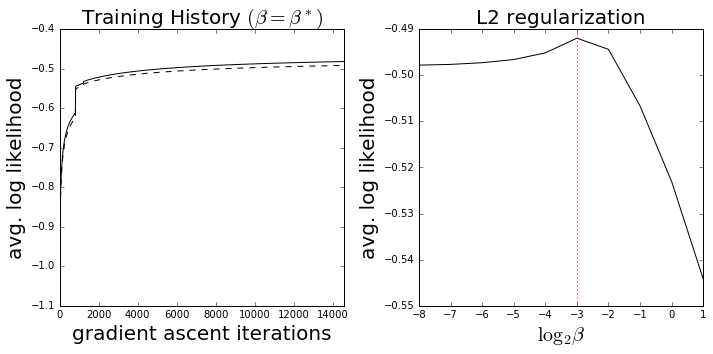

In [16]:
## Training plots

## Find the best value of beta by utilizing the CV set
jbest = [ LL_cv[i][-1] for i in range(len(LL_cv)) ].index(max([ LL_cv[i][-1] for i in range(len(LL_cv)) ]))
lambda_neg = lambda_list[jbest][0]
lambda_neutral = lambda_list[jbest][1]
lambda_pos = lambda_list[jbest][2]
LL_history = LL[jbest]
LL_cv_history = LL_cv[jbest]

fig = plt.figure(figsize=(10, 5))
## subplot 1: the training history
sub1 = fig.add_subplot(121)
sub1.set_title('Training History ' + r'$(\beta=\beta^*)$', fontsize=20)
sub1.plot(m_eval*np.array(range(len(LL_history))), LL_history, c='black')
sub1.plot(m_eval*np.array(range(len(LL_history))), LL_cv_history, c='black', linestyle='--')
sub1.set_ylabel('avg. log likelihood', fontsize=20)
sub1.set_xlabel('gradient ascent iterations', fontsize=20)
sub1.set_xlim([0, m_eval*len(LL_history)])
## subplot 2: cv analysis
sub2 = fig.add_subplot(122)
sub2.set_title('L2 regularization', fontsize=20)
sub2.plot(np.log2(beta_list), [ LL_cv[i][-1] for i in range(len(LL_cv))], color='black')
sub2.axvline(np.log2(beta_list)[jbest], linestyle=':', color='red')
sub2.set_ylabel('avg. log likelihood', fontsize=20)
sub2.set_xlabel(r'$\log_2$' + r'$\beta$', fontsize=20)
sub2.set_xlim([np.log2(beta_list)[-1], np.log2(beta_list)[0]])
## finish up
plt.tight_layout()
if small:
  plt.savefig('figures/small_MaxEnt_gradient_ascent.png')
else:
  plt.savefig('figures/MaxEnt_gradient_ascent.png')  
plt.show()


In [17]:
## Classification error

ME_pred_cv = ME_predictions(df_cv, feature_cv, lambda_neg, lambda_neutral, lambda_pos)
ME_pred_sa = ME_predictions(df_sa, feature_sa, lambda_neg, lambda_neutral, lambda_pos)
ME_pred_s140 = ME_predictions(df_s140, feature_s140, lambda_neg, lambda_neutral, lambda_pos)
## training CV set
ME_accuracy_cv_neg = 100.0*sum([ME_pred_cv[i] for i in range(len(df_cv)) if list(df_cv['sentiment'] == -1)[i] ] == df_cv[df_cv['sentiment'] == -1]['sentiment'])\
                    /len(df_cv[df_cv['sentiment'] == -1])
ME_accuracy_cv_neutral = 100.0*sum([ME_pred_cv[i] for i in range(len(df_cv)) if list(df_cv['sentiment'] == 0)[i] ] == df_cv[df_cv['sentiment'] == 0]['sentiment'])\
                    /len(df_cv[df_cv['sentiment'] == 0])
ME_accuracy_cv_pos = 100.0*sum([ME_pred_cv[i] for i in range(len(df_cv)) if list(df_cv['sentiment'] == 1)[i] ] == df_cv[df_cv['sentiment'] == 1]['sentiment'])\
                    /len(df_cv[df_cv['sentiment'] == 1])
## S140 CV set
ME_accuracy_s140_neg = 100.0*sum([ME_pred_s140[i] for i in range(len(df_s140)) if list(df_s140['sentiment'] == -1)[i] ] == df_s140[df_s140['sentiment'] == -1]['sentiment'])\
                    /len(df_s140[df_s140['sentiment'] == -1])
ME_accuracy_s140_neutral = 100.0*sum([ME_pred_s140[i] for i in range(len(df_s140)) if list(df_s140['sentiment'] == 0)[i] ] == df_s140[df_s140['sentiment'] == 0]['sentiment'])\
                    /len(df_s140[df_s140['sentiment'] == 0])
ME_accuracy_s140_pos = 100.0*sum([ME_pred_s140[i] for i in range(len(df_s140)) if list(df_s140['sentiment'] == 1)[i] ] == df_s140[df_s140['sentiment'] == 1]['sentiment'])\
                    /len(df_s140[df_s140['sentiment'] == 1])
## SA CV set
ME_accuracy_sa_neg = 100.0*sum([ME_pred_sa[i] for i in range(len(df_sa)) if list(df_sa['sentiment'] == -1)[i] ] == df_sa[df_sa['sentiment'] == -1]['sentiment'])\
                    /len(df_sa[df_sa['sentiment'] == -1])
ME_accuracy_sa_neutral = 100.0*sum([ME_pred_sa[i] for i in range(len(df_sa)) if list(df_sa['sentiment'] == 0)[i] ] == df_sa[df_sa['sentiment'] == 0]['sentiment'])\
                    /len(df_sa[df_sa['sentiment'] == 0])
ME_accuracy_sa_pos = 100.0*sum([ME_pred_sa[i] for i in range(len(df_sa)) if list(df_sa['sentiment'] == 1)[i] ] == df_sa[df_sa['sentiment'] == 1]['sentiment'])\
                    /len(df_sa[df_sa['sentiment'] == 1])

## examine performance
print 'Naive Bayes Performance:'
pt = PrettyTable(field_names=['data set', 'accuracy', '(-) accuracy', '(0) accuracy', '(+) accuracy']) 
[ pt.add_row(['CV', round(NB_accuracy_cv, 2), round(NB_accuracy_cv_neg, 2), \
              round(NB_accuracy_cv_neutral, 2), round(NB_accuracy_cv_pos, 2) ])]

[ pt.add_row(['S140', round(NB_accuracy_s140, 2), round(NB_accuracy_s140_neg, 2), \
              round(NB_accuracy_s140_neutral, 2), round(NB_accuracy_s140_pos, 2) ])]

[ pt.add_row(['SA', round(NB_accuracy_sa, 2), round(NB_accuracy_sa_neg, 2), \
              round(NB_accuracy_sa_neutral, 2), round(NB_accuracy_sa_pos, 2) ])]

#pt.align['Word'], pt.align['Count'] = 'l', 'r' #set column alignment
print pt

print 'MaxEnt Performance:'
pt = PrettyTable(field_names=['data set', 'accuracy', '(-) accuracy', '(0) accuracy', '(+) accuracy']) 
[ pt.add_row(['CV', round(100.0*sum(ME_pred_cv == df_cv['sentiment'])/len(df_cv),2), \
                                   round(ME_accuracy_cv_neg,2), round(ME_accuracy_cv_neutral,2), round(ME_accuracy_cv_pos,2) ])]

[ pt.add_row(['S140', round(100.0*sum(ME_pred_s140 == df_s140['sentiment'])/len(df_s140),2), \
                               round(ME_accuracy_s140_neg,2), round(ME_accuracy_s140_neutral,2), round(ME_accuracy_s140_pos,2) ])]

[ pt.add_row(['SA', round(100.0*sum(ME_pred_sa == df_sa['sentiment'])/len(df_sa),2), \
                             round(ME_accuracy_sa_neg,2), round(ME_accuracy_sa_neutral,2), round(ME_accuracy_sa_pos,2) ])]

#pt.align['Word'], pt.align['Count'] = 'l', 'r' #set column alignment
print pt

Naive Bayes Performance:
+----------+----------+--------------+--------------+--------------+
| data set | accuracy | (-) accuracy | (0) accuracy | (+) accuracy |
+----------+----------+--------------+--------------+--------------+
|    CV    |   77.8   |     68.7     |    93.85     |    70.87     |
|   S140   |  55.73   |    50.28     |    64.75     |    54.14     |
|    SA    |  51.94   |    33.77     |    57.82     |    46.31     |
+----------+----------+--------------+--------------+--------------+
MaxEnt Performance:
+----------+----------+--------------+--------------+--------------+
| data set | accuracy | (-) accuracy | (0) accuracy | (+) accuracy |
+----------+----------+--------------+--------------+--------------+
|    CV    |   80.1   |    77.05     |    91.45     |     71.8     |
|   S140   |  62.78   |    58.76     |    58.27     |    70.17     |
|    SA    |  48.25   |    49.01     |    46.91     |    53.44     |
+----------+----------+--------------+--------------+-----

In [18]:
## examine sentiment
pt = PrettyTable(field_names=['data set', 'avg. sentiment', 'NB pred', 'ME pred']) 
[ pt.add_row(['CV', round(1.0*sum(df_cv['sentiment'])/len(df_cv),3), \
              round(1.0*sum(df_cv['NB predictions'])/len(df_cv),3), round(1.0*sum(ME_pred_cv)/len(df_cv),3) ]) ]
[ pt.add_row(['S140', round(1.0*sum(df_s140['sentiment'])/len(df_s140),3), \
              round(1.0*sum(df_s140['NB predictions'])/len(df_s140),3), round(1.0*sum(ME_pred_s140)/len(df_s140),3) ]) ]
[ pt.add_row(['SA', round(1.0*sum(df_sa['sentiment'])/len(df_sa),3), \
              round(1.0*sum(df_sa['NB predictions'])/len(df_sa),3), round(1.0*sum(ME_pred_sa)/len(df_sa),3) ]) ]
print pt

+----------+----------------+---------+---------+
| data set | avg. sentiment | NB pred | ME pred |
+----------+----------------+---------+---------+
|    CV    |      0.0       |   0.04  |  -0.012 |
|   S140   |     0.008      |   0.0   |  0.091  |
|    SA    |     -0.023     |   0.26  |  0.207  |
+----------+----------------+---------+---------+


In [19]:
## Work out the confusion matrices for the NB predictions
M_NB_cv_pp = 1.0*sum(((df_cv['sentiment'] == 1) & (df_cv['NB predictions'] == 1)))/len(df_cv)
M_NB_cv_p0 = 1.0*sum(((df_cv['sentiment'] == 1) & (df_cv['NB predictions'] == 0)))/len(df_cv)
M_NB_cv_pn = 1.0*sum(((df_cv['sentiment'] == 1) & (df_cv['NB predictions'] == -1)))/len(df_cv)
M_NB_cv_0p = 1.0*sum(((df_cv['sentiment'] == 0) & (df_cv['NB predictions'] == 1)))/len(df_cv)
M_NB_cv_00 = 1.0*sum(((df_cv['sentiment'] == 0) & (df_cv['NB predictions'] == 0)))/len(df_cv)
M_NB_cv_0n = 1.0*sum(((df_cv['sentiment'] == 0) & (df_cv['NB predictions'] == -1)))/len(df_cv)
M_NB_cv_np = 1.0*sum(((df_cv['sentiment'] == -1) & (df_cv['NB predictions'] == 1)))/len(df_cv)
M_NB_cv_n0 = 1.0*sum(((df_cv['sentiment'] == -1) & (df_cv['NB predictions'] == 0)))/len(df_cv)
M_NB_cv_nn = 1.0*sum(((df_cv['sentiment'] == -1) & (df_cv['NB predictions'] == -1)))/len(df_cv)

M_NB_s140_pp = 1.0*sum(((df_s140['sentiment'] == 1) & (df_s140['NB predictions'] == 1)))/len(df_s140)
M_NB_s140_p0 = 1.0*sum(((df_s140['sentiment'] == 1) & (df_s140['NB predictions'] == 0)))/len(df_s140)
M_NB_s140_pn = 1.0*sum(((df_s140['sentiment'] == 1) & (df_s140['NB predictions'] == -1)))/len(df_s140)
M_NB_s140_0p = 1.0*sum(((df_s140['sentiment'] == 0) & (df_s140['NB predictions'] == 1)))/len(df_s140)
M_NB_s140_00 = 1.0*sum(((df_s140['sentiment'] == 0) & (df_s140['NB predictions'] == 0)))/len(df_s140)
M_NB_s140_0n = 1.0*sum(((df_s140['sentiment'] == 0) & (df_s140['NB predictions'] == -1)))/len(df_s140)
M_NB_s140_np = 1.0*sum(((df_s140['sentiment'] == -1) & (df_s140['NB predictions'] == 1)))/len(df_s140)
M_NB_s140_n0 = 1.0*sum(((df_s140['sentiment'] == -1) & (df_s140['NB predictions'] == 0)))/len(df_s140)
M_NB_s140_nn = 1.0*sum(((df_s140['sentiment'] == -1) & (df_s140['NB predictions'] == -1)))/len(df_s140)

M_NB_sa_pp = 1.0*sum(((df_sa['sentiment'] == 1) & (df_sa['NB predictions'] == 1)))/len(df_sa)
M_NB_sa_p0 = 1.0*sum(((df_sa['sentiment'] == 1) & (df_sa['NB predictions'] == 0)))/len(df_sa)
M_NB_sa_pn = 1.0*sum(((df_sa['sentiment'] == 1) & (df_sa['NB predictions'] == -1)))/len(df_sa)
M_NB_sa_0p = 1.0*sum(((df_sa['sentiment'] == 0) & (df_sa['NB predictions'] == 1)))/len(df_sa)
M_NB_sa_00 = 1.0*sum(((df_sa['sentiment'] == 0) & (df_sa['NB predictions'] == 0)))/len(df_sa)
M_NB_sa_0n = 1.0*sum(((df_sa['sentiment'] == 0) & (df_sa['NB predictions'] == -1)))/len(df_sa)
M_NB_sa_np = 1.0*sum(((df_sa['sentiment'] == -1) & (df_sa['NB predictions'] == 1)))/len(df_sa)
M_NB_sa_n0 = 1.0*sum(((df_sa['sentiment'] == -1) & (df_sa['NB predictions'] == 0)))/len(df_sa)
M_NB_sa_nn = 1.0*sum(((df_sa['sentiment'] == -1) & (df_sa['NB predictions'] == -1)))/len(df_sa)

M_NB_cv = np.asarray([[M_NB_cv_pp, M_NB_cv_p0, M_NB_cv_pn], \
                      [M_NB_cv_0p, M_NB_cv_00, M_NB_cv_0n], [M_NB_cv_np, M_NB_cv_n0, M_NB_cv_nn]])

M_NB_s140 = np.asarray([[M_NB_s140_pp, M_NB_s140_p0, M_NB_s140_pn], \
                      [M_NB_s140_0p, M_NB_s140_00, M_NB_s140_0n], [M_NB_s140_np, M_NB_s140_n0, M_NB_s140_nn]])

M_NB_sa = np.asarray([[M_NB_sa_pp, M_NB_sa_p0, M_NB_sa_pn], \
                      [M_NB_sa_0p, M_NB_sa_00, M_NB_sa_0n], [M_NB_sa_np, M_NB_sa_n0, M_NB_sa_nn]])

print M_NB_cv
print '\n'
print M_NB_s140
print '\n'
print M_NB_sa

[[ 0.23622309  0.04409779  0.05301246]
 [ 0.01783383  0.31283004  0.00266947]
 [ 0.07035277  0.03398522  0.22899534]]


[[ 0.1971831   0.11871227  0.04828974]
 [ 0.04225352  0.18108652  0.05633803]
 [ 0.04426559  0.13279678  0.17907445]]


[[ 0.06935976  0.07202744  0.00838415]
 [ 0.24695122  0.39176829  0.03887195]
 [ 0.04954268  0.06478659  0.05830793]]
